In [49]:
import pandas as pd
import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from ipywidgets import SelectMultiple, interactive_output, VBox
from IPython.display import display

import datetime as dt

import json

import random

In [50]:
# Reading the latest file

latest_file = r'./data/nhs_infections/coronavirus-cases_202005311434.csv'
cases_df = pd.read_csv(latest_file)

# Convertine to datetime column
cases_df['Date'] = pd.to_datetime(cases_df['Specimen date'])

In [51]:
cases_df[cases_df['Area code']=='E09000001'].shape

(22, 12)

In [52]:
cases_df[cases_df['Area code']=='E08000015'].shape

(160, 12)

# Feature Engineering

In [5]:
# This will be used to create delta_time features

imp_dates = {
    'cases_over_100':[dt.datetime(2020,3,2),dt.datetime(2020,12,31)],
    'schools_closed':[dt.datetime(2020,3,15),dt.datetime(2020,5,31)],
    'restaurants_cafes_closed':[dt.datetime(2020,3,20),dt.datetime(2020,6,30)],
    'nationwide_lockdown':[dt.datetime(2020,3,23),dt.datetime(2020,8,31)]
}

In [53]:
population_data = pd.read_csv(r'./data/regional/population.csv')

In [54]:
population_data = population_data.iloc[:,:4]

In [55]:
set(cases_df['Area code'].unique()) - set(population_data['Area code'].unique())

{'E07000004', 'E07000005', 'E07000006', 'E07000007', 'E10000002'}

In [56]:
cases_df = pd.merge(cases_df, population_data, on='Area code')

In [57]:
cases_df['Population'] = cases_df['All ages'].apply(lambda x : int(x.replace(',','')))

In [58]:
cases_df.drop(columns=['All ages'],inplace=True)

In [59]:
# Creating a dataframe for each unique area code, these are districts / cities in England, i.e. Harrow, Brent, etc.
# df for each unique area stored in dictionary

areawise_data = {}

for area in cases_df['Area code'].unique():
    areawise_data[area] = cases_df[cases_df['Area code']==area].sort_values('Date').drop_duplicates(subset=['Date'])

In [60]:
for area_code in areawise_data:
    area_df = areawise_data[area_code]
    
    cases_data = area_df['Cumulative lab-confirmed cases'].ravel()
    cc_rate = area_df['Cumulative lab-confirmed cases rate'].ravel()
    daily_cases = area_df['Daily lab-confirmed cases'].ravel()
    population = area_df['Population'].ravel()[0]
    
    
    gradient_n7 = []
    gradient_n3 = []
    gradient_0 = []
    current_r0 = []
    previous_day_daily_cases = []
    previous_day_cumulative_cases = []
    active_infections = []
    current_suseptible = []
    recovered=[]
    previous_day_cc_rate = []
    real_r0 = []
    
    
    
    for i in range(area_df.shape[0]):
        if i>=7:
            
            # Using np.gradient to collect data of change in cases in past 7 days
            # These gradients can be used as features for mlp or regressors
            
            gradient = np.gradient([cases_data[i-7], cases_data[i-4], cases_data[i-1]])
            gradient_n7.append(gradient[0])
            gradient_n3.append(gradient[1])
            gradient_0.append(gradient[2])
            previous_day_daily_cases.append(daily_cases[i-1])
            previous_day_cumulative_cases.append(cases_data[i-1])
            previous_day_cc_rate.append(cc_rate[i-1])
            # calculating current r0
            real_r0.append((cases_data[i] - cases_data[i-3])/(cases_data[i-4]-cases_data[i-7]))   
            current_r0.append((cases_data[i-1] - cases_data[i-3])/(cases_data[i-4]-cases_data[i-6]))   

            
        else:
            
            gradient_n7.append(np.nan)
            gradient_n3.append(np.nan)
            gradient_0.append(np.nan)
            current_r0.append(np.nan)
            previous_day_daily_cases.append(np.nan)
            previous_day_cumulative_cases.append(np.nan)
            previous_day_cc_rate.append(np.nan)
            real_r0.append(np.nan)
            
        if i>=15:
            active_infections.append(cases_data[i-1] - cases_data[i-15])
            recovered.append(cases_data[i-1] - active_infections[i])
            current_suseptible.append(population - active_infections[i] - recovered[i])
        elif i>1:
            active_infections.append(cases_data[i-1])
            recovered.append(0)
            current_suseptible.append(population - active_infections[i] - recovered[i])
        else:
            active_infections.append(0)
            recovered.append(0)
            current_suseptible.append(population)
            
            

    area_df['grad_0'] = gradient_0
    area_df['grad_n3'] = gradient_n3
    area_df['grad_n7'] = gradient_n7
    area_df['current_r0'] = current_r0
    area_df['previous_day_daily_cases'] = previous_day_daily_cases
    area_df['previous_day_cumulative_cases'] = previous_day_cumulative_cases
    area_df['previous_day_cc_rate'] = previous_day_cc_rate
    area_df['rolling_previous_day_cc_rate_3'] = area_df['previous_day_cc_rate'].rolling(3).mean()
    area_df['rolling_r0_3'] = area_df['current_r0'].rolling(3).mean()
    area_df['rolling_r0_7'] = area_df['current_r0'].rolling(7).mean()
    area_df['rolling_previous_day_daily_cases_4'] = area_df['previous_day_daily_cases'].rolling(4).mean()
    area_df['active_infections'] = active_infections
    area_df['currently_suseptible'] = current_suseptible
    area_df['recovered'] = recovered
    area_df['real_r0'] = real_r0
    
    area_df['rolling_real_r0_3'] = area_df['real_r0'].rolling(3).mean()
    area_df['rolling_real_r0_7'] = area_df['real_r0'].rolling(7).mean()
    
    
    area_df['K_value_1'] = np.log(area_df['grad_n3']/3)
    area_df['K_value_2'] = np.log(area_df['grad_n3'])/3
    rolling_r0_7 = area_df['rolling_r0_7'].ravel()
    previous_rolling_r0_7 = []
    r0_7_gradient = []
    for i in range(area_df.shape[0]):
        if i>=7:
            previous_rolling_r0_7.append(rolling_r0_7[i-1])
            r0_7_gradient.append(np.gradient([rolling_r0_7[i-1], rolling_r0_7[i]])[0])
        else:
            previous_rolling_r0_7.append(np.nan)
            r0_7_gradient.append(np.nan)
    area_df['previous_rolling_r0_7'] = previous_rolling_r0_7
    area_df['r0_7_gradient'] = r0_7_gradient
    
    area_df['risk_score'] = 1 - (current_suseptible[i] - active_infections[i])/population
    
    areawise_data[area_code] = area_df.iloc[8:]

In [61]:
def add_lag_featuers(df, date_col, imp_dates):
    for imp_measure, imp_dates in imp_dates.items():
        df[imp_measure+'_startdelta'] = df[date_col].apply(lambda x : (x - imp_dates[0]).days)
        df[imp_measure+'_enddelta'] = df[date_col].apply(lambda x : (x - imp_dates[1]).days)
        df[imp_measure+'_active'] = df[date_col].apply(lambda x : int(x >= imp_dates[0] and x <= imp_dates[1]))
    return df

In [62]:
cases_data = pd.concat([df for df in areawise_data.values()])

cases_data = add_lag_featuers(cases_data, 'Date', imp_dates)

cases_data.to_pickle(r'./data/processed/cases_data.pickle')

In [63]:
cases_data['Area code'].nunique()

347

In [64]:
all_data['Area code'].nunique()

307

In [16]:
demo_uk = pd.read_csv(r'./data/regional/population_density_age.csv')

In [19]:
demo_uk.sample(3)

,Area code,name,median age,population density,population density deciles,Age 0 to 15,Age 65 plus,Age 85 plus,Working age 16 to 64,Old Age Dependency Ratio,Dependency Ratio
263,E08000019,Sheffield,35.4,1589,8,18.1,16.1,2.2,65.8,24.6,52.1
189,E07000176,Rushcliffe,43.9,291,4,18.5,21.2,3.1,60.4,35.0,65.6
82,E07000046,Torridge,50.7,69,1,16.0,27.7,3.4,56.3,49.3,77.7


In [20]:
all_data = pd.merge(cases_data, demo_uk, on='Area code')

In [21]:
all_data['ref_r0'] = all_data['Cumulative lab-confirmed cases']/(all_data['Cumulative lab-confirmed cases'] - all_data['grad_n3'])

In [22]:
all_data['risk_score'] = 1 - (all_data['currently_suseptible'] - all_data['Daily lab-confirmed cases'] + all_data['recovered'])/all_data['Population']

In [23]:
all_data['risk_score_2'] = 1 - (all_data['currently_suseptible'] - (all_data['rolling_r0_7']*all_data['active_infections']/14) + all_data['recovered'])/all_data['Population']

In [24]:
sample_data = all_data[all_data['Area code']=='E08000015']

In [25]:
all_data.drop(columns=['Previously reported daily cases', 'Change in daily cases', 'Previously reported cumulative cases', 'Change in cumulative cases'], inplace=True)

# Visualising Newly Created Features

In [26]:
def plot_features(df, cols):
    plt.figure(figsize=(8,5), dpi=100)
    for col in cols:
        plt.plot(df['Date'], df[col], label=col)
    plt.xticks(rotation=45)
    plt.grid(which='both', alpha=0.25)
    plt.xlabel('Date')
    plt.legend()
    plt.show()
    

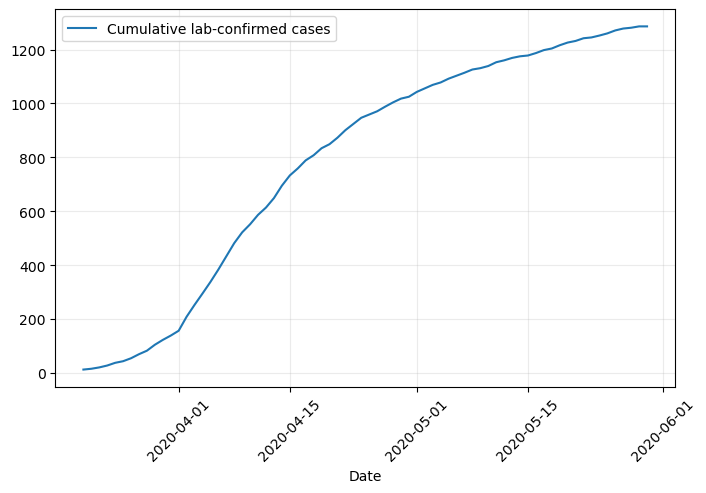

In [27]:
plot_features(sample_data, ['Cumulative lab-confirmed cases'])

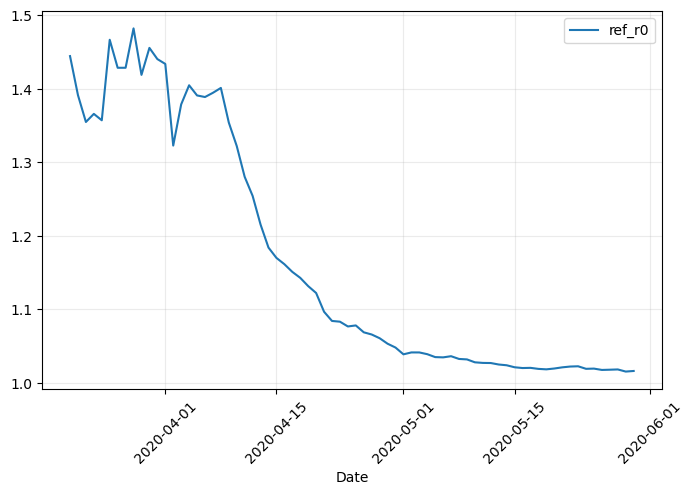

In [28]:
plot_features(sample_data, ['ref_r0'])

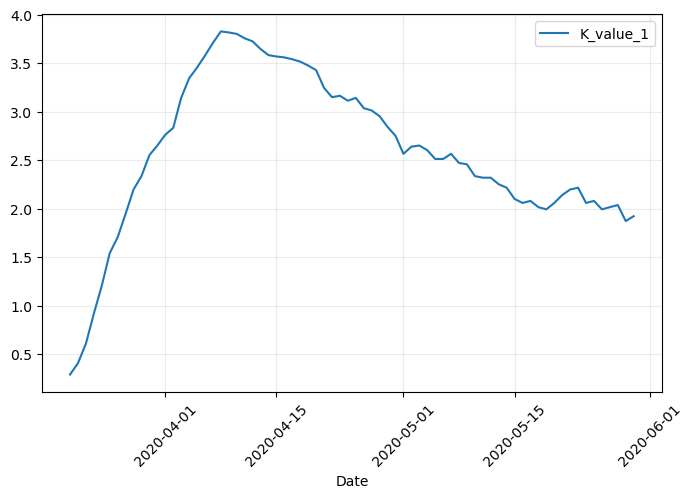

In [29]:
plot_features(sample_data, ['K_value_1'])

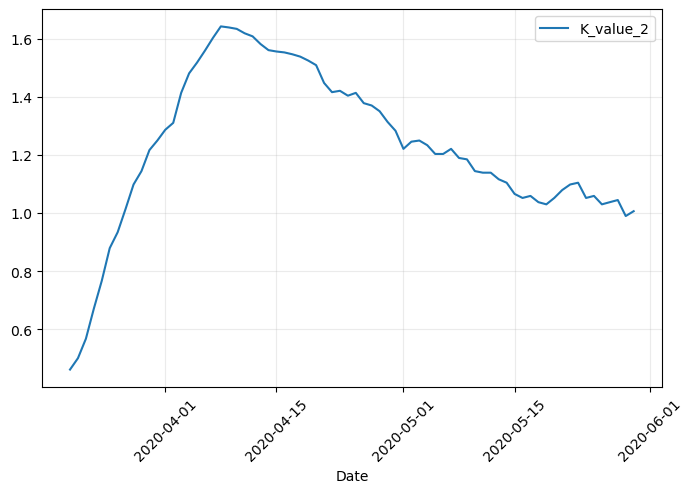

In [30]:
plot_features(sample_data, ['K_value_2'])

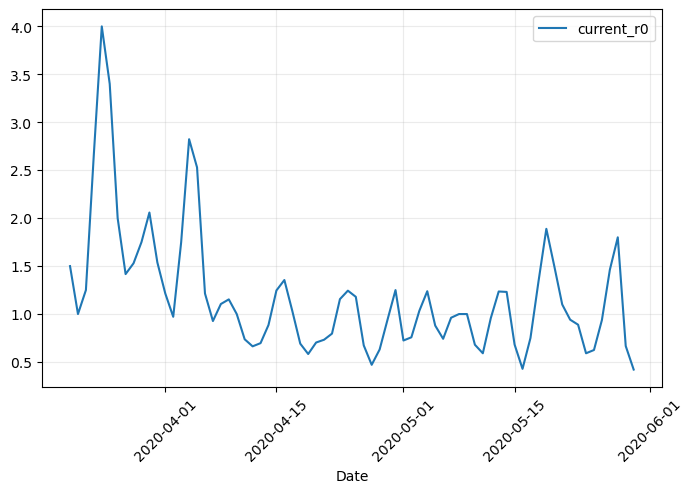

In [31]:
plot_features(sample_data, ['current_r0'])

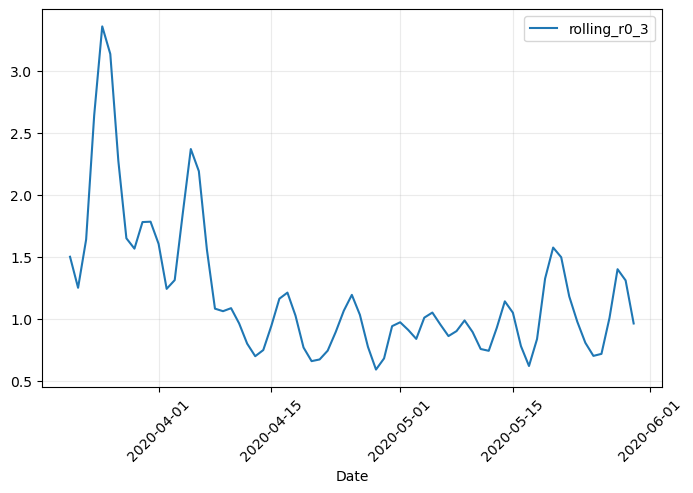

In [32]:
plot_features(sample_data, ['rolling_r0_3'])

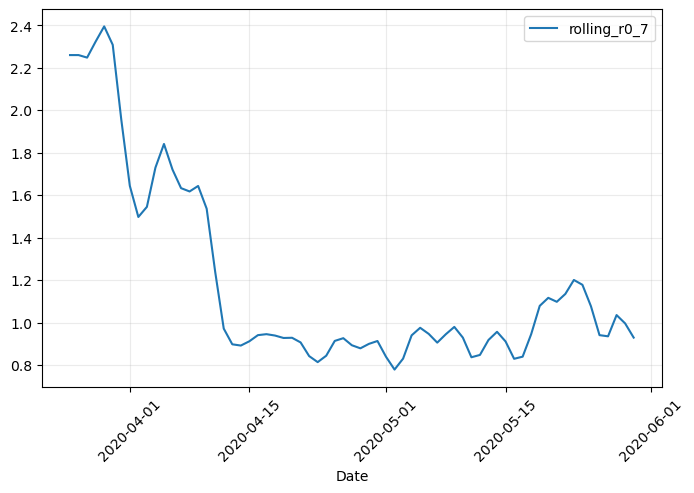

In [33]:
plot_features(sample_data, ['rolling_r0_7'])

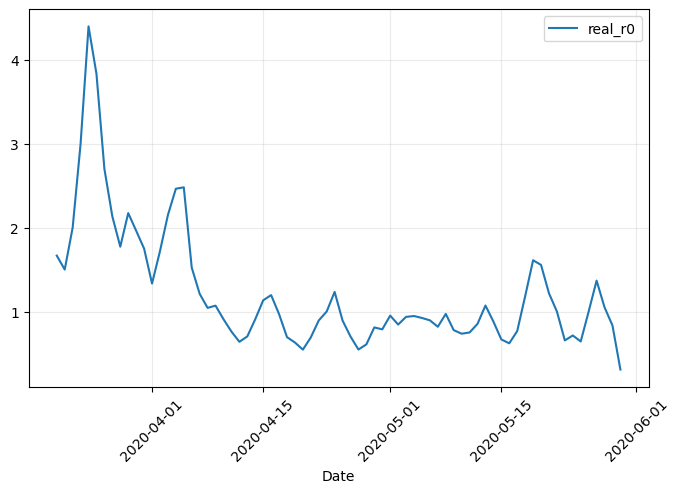

In [34]:
plot_features(sample_data, ['real_r0'])

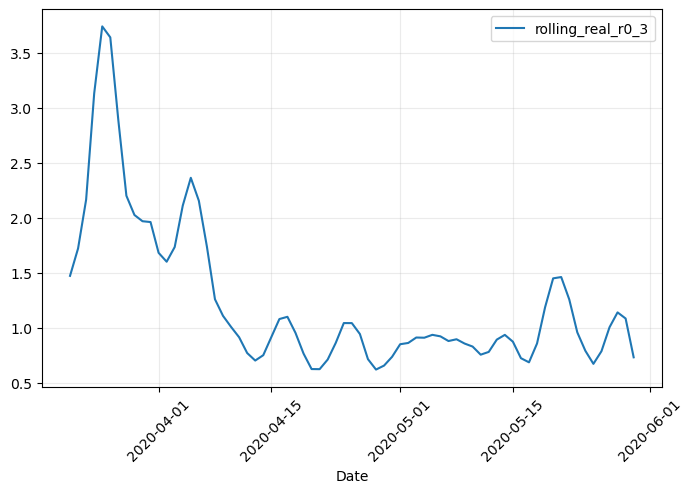

In [35]:
plot_features(sample_data, ['rolling_real_r0_3'])

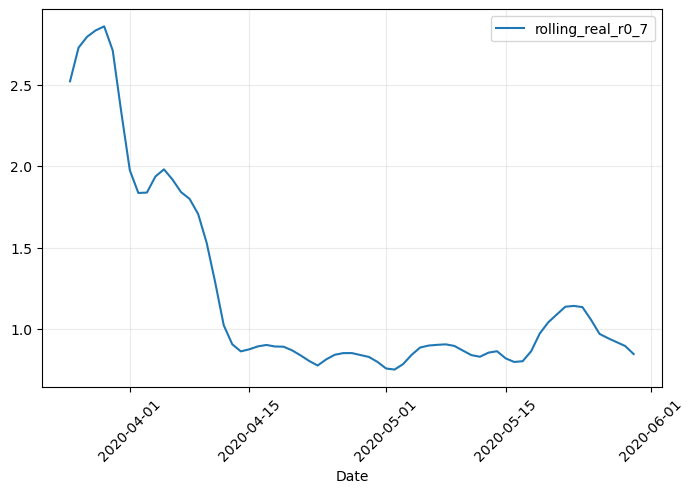

In [36]:
plot_features(sample_data, ['rolling_real_r0_7'])

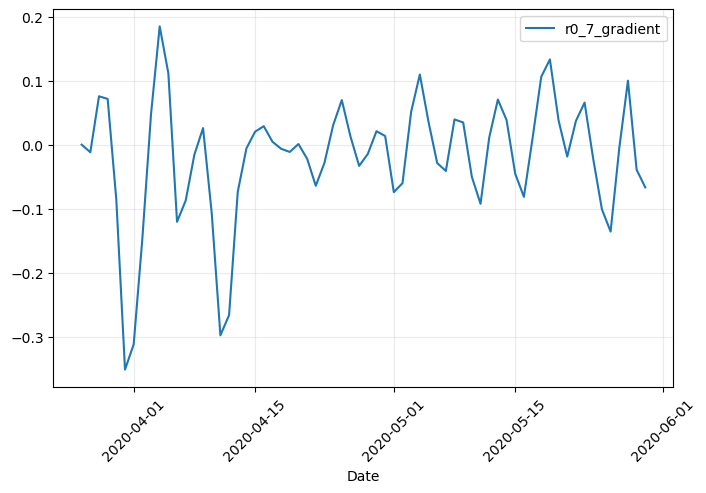

In [37]:
plot_features(sample_data, ['r0_7_gradient'])

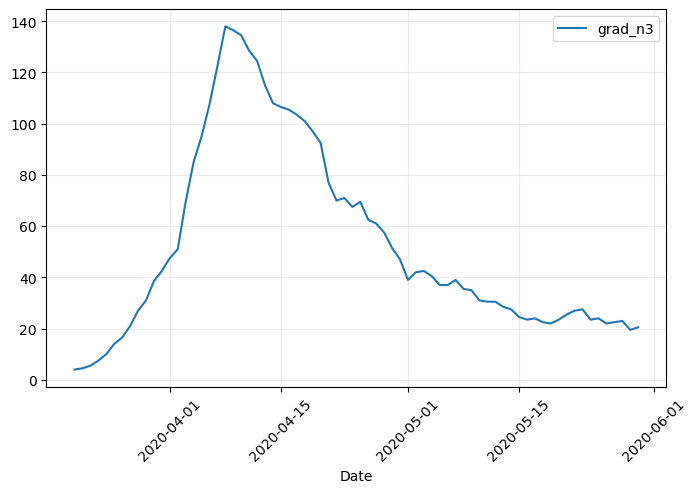

In [38]:
plot_features(sample_data, ['grad_n3'])

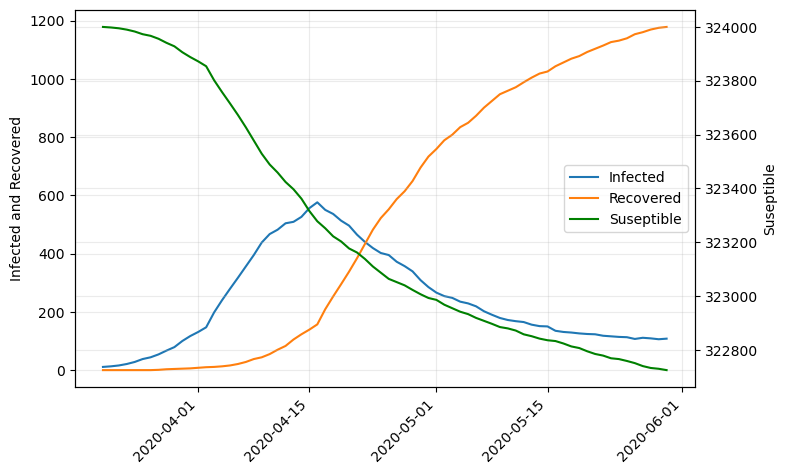

In [39]:
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
ln1 = ax.plot(sample_data['Date'], sample_data['active_infections'], label='Infected')
ln2 = ax.plot(sample_data['Date'], sample_data['recovered'], label='Recovered')
plt.grid(which='both', alpha=0.25)

ax2=ax.twinx()
ln3 = ax2.plot(sample_data['Date'], sample_data['currently_suseptible'], label='Suseptible', c='g')

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]

ax.legend(lns, labs, loc=5)
ax.set_ylabel('Infected and Recovered')
ax2.set_ylabel('Suseptible')

plt.grid(which='both', alpha=0.25)

for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

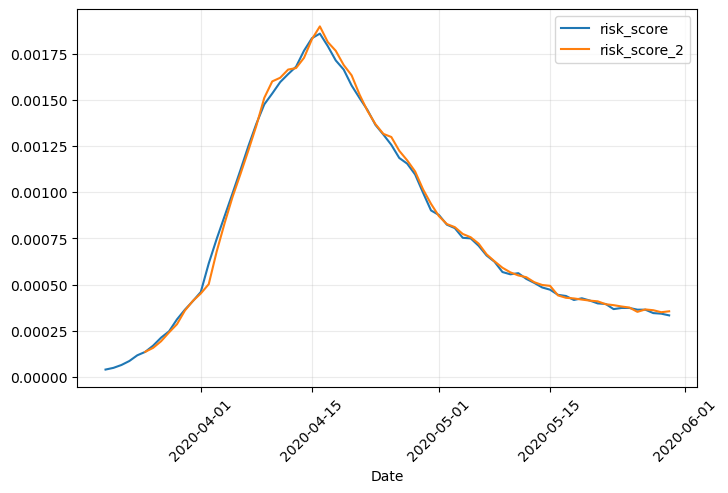

In [40]:
plot_features(sample_data, ['risk_score', 'risk_score_2'])

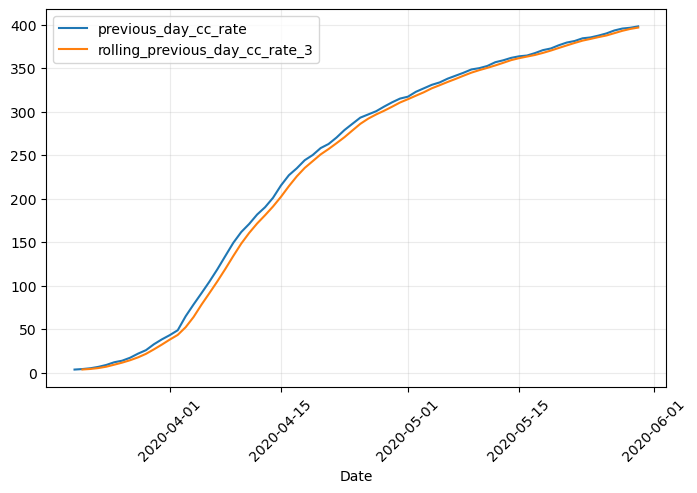

In [41]:
plot_features(sample_data, ['previous_day_cc_rate', 'rolling_previous_day_cc_rate_3'])

# Adding Area Data

In [42]:
areas_uk = pd.read_csv(r'./data/regional/areas_uk.csv')

In [43]:
missing_areas = set(all_data['Area code'].unique()) - set(areas_uk['Area code'].unique())

In [44]:
areas_data = all_data[['Area name', 'Area code']].drop_duplicates().reset_index().drop(columns=['index'])

In [45]:
areas_data[areas_data['Area code'].isin(missing_areas)]

,Area name,Area code
69,Somerset West and Taunton,E07000246
70,West Suffolk,E07000245
71,East Suffolk,E07000244
257,Dorset,E06000059
258,"Bournemouth, Christchurch and Poole",E06000058


In [46]:
all_data = pd.merge(all_data, areas_uk, on='Area code')

In [47]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18109 entries, 0 to 18108
Data columns (total 62 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Area name                            18109 non-null  object        
 1   Area code                            18109 non-null  object        
 2   Area type                            18109 non-null  object        
 3   Specimen date                        18109 non-null  object        
 4   Daily lab-confirmed cases            18108 non-null  float64       
 5   Cumulative lab-confirmed cases       18109 non-null  int64         
 6   Cumulative lab-confirmed cases rate  18109 non-null  float64       
 7   Date                                 18109 non-null  datetime64[ns]
 8   Name                                 18109 non-null  object        
 9   Geography1                           18109 non-null  object        
 10  Population

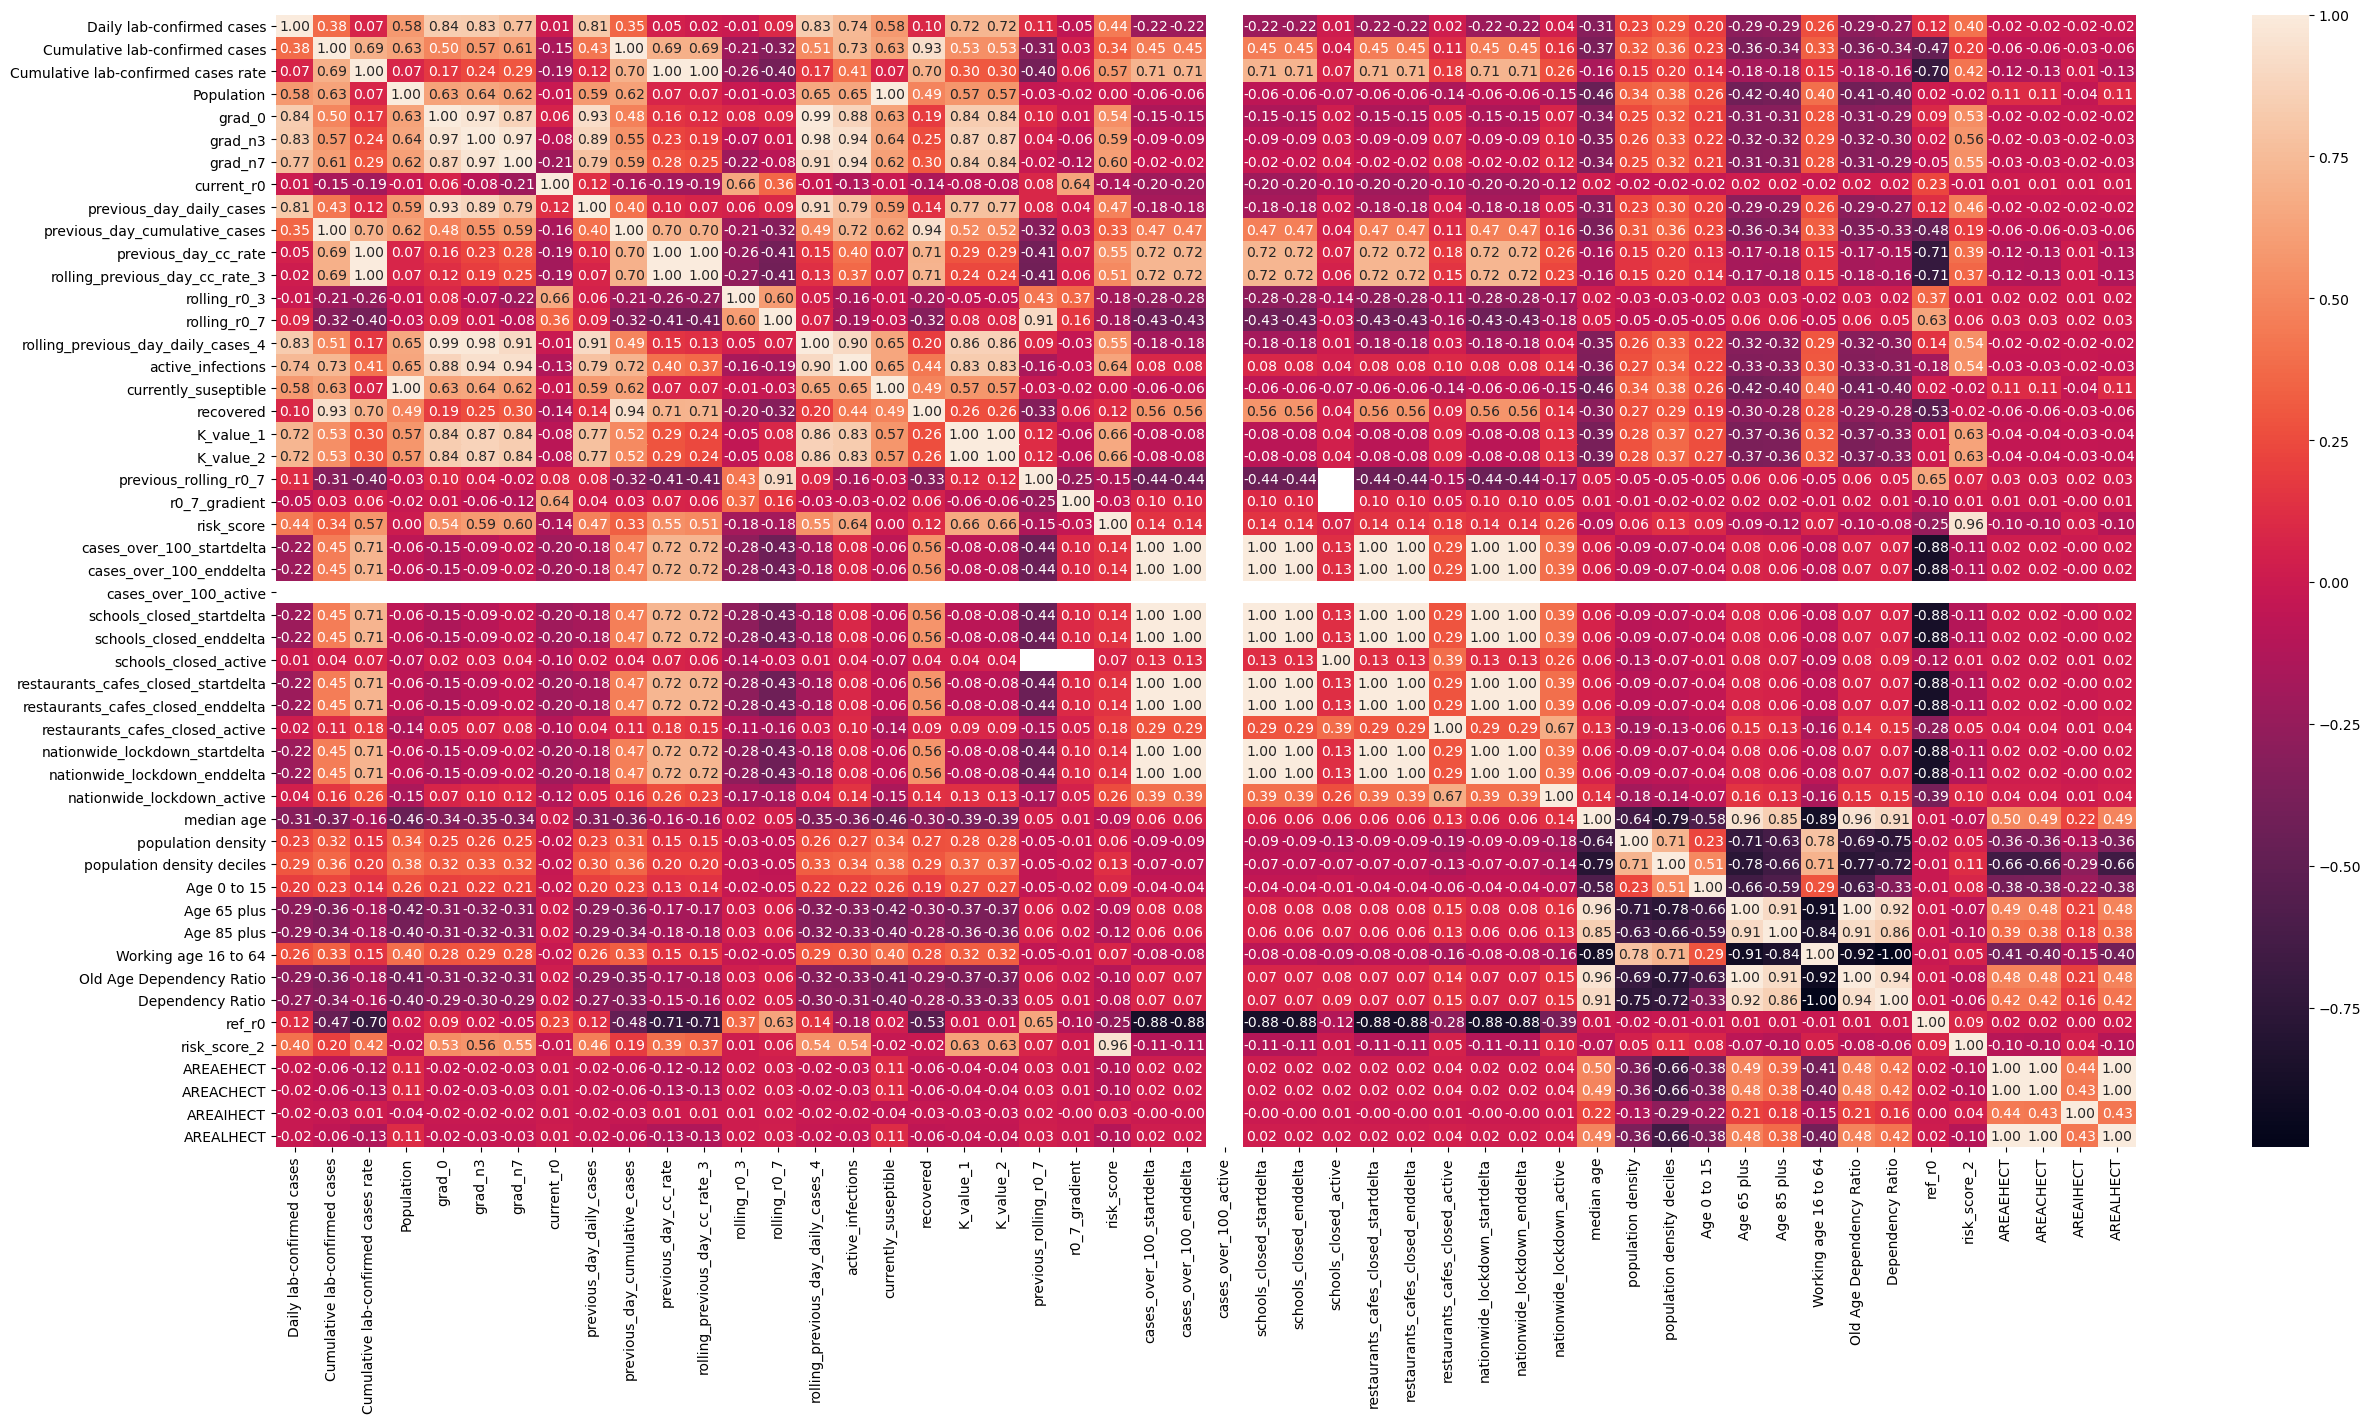

In [47]:
plt.figure(figsize=(30,15), dpi=100)
sns.heatmap(all_data.corr(), annot=True, fmt='.2f')

In [85]:
all_data[all_data['Area code']=='E08000015']

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Cumulative lab-confirmed cases,Cumulative lab-confirmed cases rate,Date,Name,Geography1,...,Working age 16 to 64,Old Age Dependency Ratio,Dependency Ratio,ref_r0,risk_score_2,LAD16NM,AREAEHECT,AREACHECT,AREAIHECT,AREALHECT
3651,Wirral,E08000015,Lower tier local authority,2020-03-20,2.0,13,4.0,2020-03-20,Wirral,Metropolitan District,...,59.5,36.8,68.1,1.444444,NaN,Wirral,25639.91,15704.63,0.0,15704.63
3652,Wirral,E08000015,Lower tier local authority,2020-03-21,3.0,16,4.9,2020-03-21,Wirral,Metropolitan District,...,59.5,36.8,68.1,1.391304,NaN,Wirral,25639.91,15704.63,0.0,15704.63
3653,Wirral,E08000015,Upper tier local authority,2020-03-22,5.0,21,6.5,2020-03-22,Wirral,Metropolitan District,...,59.5,36.8,68.1,1.354839,NaN,Wirral,25639.91,15704.63,0.0,15704.63
3654,Wirral,E08000015,Lower tier local authority,2020-03-23,7.0,28,8.7,2020-03-23,Wirral,Metropolitan District,...,59.5,36.8,68.1,1.365854,NaN,Wirral,25639.91,15704.63,0.0,15704.63
3655,Wirral,E08000015,Lower tier local authority,2020-03-24,10.0,38,11.8,2020-03-24,Wirral,Metropolitan District,...,59.5,36.8,68.1,1.357143,NaN,Wirral,25639.91,15704.63,0.0,15704.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3718,Wirral,E08000015,Upper tier local authority,2020-05-26,11.0,1271,393.2,2020-05-26,Wirral,Metropolitan District,...,59.5,36.8,68.1,1.017614,0.000352,Wirral,25639.91,15704.63,0.0,15704.63
3719,Wirral,E08000015,Lower tier local authority,2020-05-27,7.0,1278,395.4,2020-05-27,Wirral,Metropolitan District,...,59.5,36.8,68.1,1.017921,0.000365,Wirral,25639.91,15704.63,0.0,15704.63
3720,Wirral,E08000015,Lower tier local authority,2020-05-28,3.0,1281,396.3,2020-05-28,Wirral,Metropolitan District,...,59.5,36.8,68.1,1.018283,0.000361,Wirral,25639.91,15704.63,0.0,15704.63
3721,Wirral,E08000015,Lower tier local authority,2020-05-29,5.0,1286,397.9,2020-05-29,Wirral,Metropolitan District,...,59.5,36.8,68.1,1.015397,0.000350,Wirral,25639.91,15704.63,0.0,15704.63


In [48]:
all_data.to_pickle(r'./data/processed/all_data_updated.pickle')